In [2]:
import sys
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import quant_utils.data_moudle as dm
from dateutil.parser import parse
from quant_utils.performance import periods_performance, Performance
from quant_utils.constant import DB_CONN_JJTG_DATA
sys.path.append("D:/FundResearch/")
from portfolio.portfolio_backtest_new import PortfolioBacktest

<Axes: xlabel='TRADE_DT'>

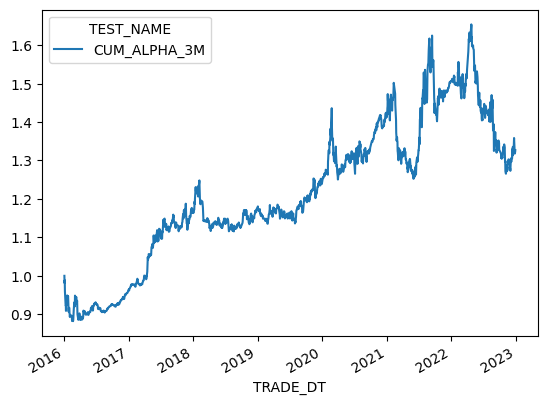

In [9]:
test = PortfolioBacktest([10])

nav = test.get_backtest_nav().query("TRADE_DT >= '20160101' and TRADE_DT <= '20221231'")
result = []
for test_name, df in nav.groupby(by=["TEST_CODE", "TEST_NAME"]):
    temp = df.pivot_table(index="TRADE_DT", columns="PORTFOLIO_NAME", values="LOG_RETURN_RATE")
    temp["ALPHA"] = (temp["01"] - temp["10"]).cumsum()/100
    temp = temp[["ALPHA"]].reset_index()
    temp["TEST_NAME"] = test_name[1]
    result.append(temp)
result = pd.concat(result)
result["TRADE_DT"] = pd.to_datetime(result["TRADE_DT"])

nav_df = result.pivot_table(
    index="TRADE_DT", 
    columns="TEST_NAME", 
    values="ALPHA"
).dropna()
nav_df = np.exp(nav_df - nav_df.iloc[0,:])
ret_df = nav_df.pct_change().fillna(0)
nav_df.plot()

In [10]:
Performance(nav_df["CUM_ALPHA_3M"]).stats().T

,起始日期,结束日期,累计收益率,年化收益率,年化波动率,收益波动比,最大回撤,年化收益回撤比,最大回撤日,最大回撤修复
0,2016-01-04,2022-12-30,0.327019,0.041297,0.123105,0.335458,0.234809,0.175873,20221107,99999


<Axes: xlabel='TRADE_DT'>

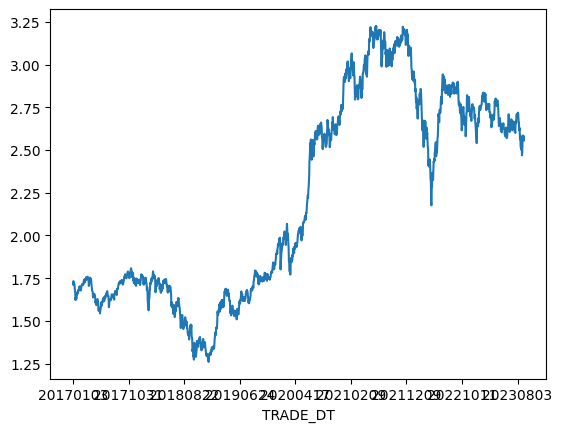

In [8]:
test.get_backtest_nav().query("TRADE_DT>='20170101' and PORTFOLIO_NAME =='10'").set_index("TRADE_DT")["NAV"].plot()

In [10]:
def get_fund_alpha(trade_dt, level_1):
    print(trade_dt)
    query_sql = f"""
    WITH a AS (
        SELECT
            END_DATE,
            TICKER_SYMBOL,
            `LEVEL`,
            sum( CASE INDICATOR WHEN 'IR' THEN 3M ELSE 0 END ) AS IR_3M,
            sum( CASE INDICATOR WHEN 'IR' THEN 6M ELSE 0 END ) AS IR_6M,
            sum( CASE INDICATOR WHEN 'IR' THEN 9M ELSE 0 END ) AS IR_9M,
            sum( CASE INDICATOR WHEN 'IR' THEN 1Y ELSE 0 END ) AS IR_1Y,
            sum( CASE INDICATOR WHEN 'IR' THEN 2Y ELSE 0 END ) AS IR_2Y,-- 		sum( CASE INDICATOR WHEN 'IR' THEN 3Y ELSE 0 END ) AS IR_3Y,
            sum( CASE INDICATOR WHEN 'MAXDD' THEN 3M ELSE 0 END ) AS MAXDD_3M,
            sum( CASE INDICATOR WHEN 'MAXDD' THEN 6M ELSE 0 END ) AS MAXDD_6M,
            sum( CASE INDICATOR WHEN 'MAXDD' THEN 9M ELSE 0 END ) AS MAXDD_9M,
            sum( CASE INDICATOR WHEN 'MAXDD' THEN 1Y ELSE 0 END ) AS MAXDD_1Y,
            sum( CASE INDICATOR WHEN 'MAXDD' THEN 2Y ELSE 0 END ) AS MAXDD_2Y,-- 		sum( CASE INDICATOR WHEN 'MAXDD' THEN 3Y ELSE 0 END ) AS MAXDD_3Y,
            sum( CASE INDICATOR WHEN 'CUM_ALPHA' THEN 3M ELSE 0 END ) AS ALPHA_3M,
            sum( CASE INDICATOR WHEN 'CUM_ALPHA' THEN 6M ELSE 0 END ) AS ALPHA_6M,
            sum( CASE INDICATOR WHEN 'CUM_ALPHA' THEN 9M ELSE 0 END ) AS ALPHA_9M,
            sum( CASE INDICATOR WHEN 'CUM_ALPHA' THEN 1Y ELSE 0 END ) AS ALPHA_1Y,
            sum( CASE INDICATOR WHEN 'CUM_ALPHA' THEN 2Y ELSE 0 END ) AS ALPHA_2Y -- 		sum( CASE INDICATOR WHEN 'CUM_ALPHA' THEN 3Y ELSE 0 END ) AS ALPHA_3Y
            
        FROM
            fund_derivatives_fund_alpha_performance 
        WHERE
            1 = 1 
            AND END_DATE = '{trade_dt}'
            and 2Y is not NULL
        GROUP BY
            END_DATE,
            TICKER_SYMBOL,
            `LEVEL` 
        ),
        b AS (
        SELECT
            a.END_DATE,
            a.TICKER_SYMBOL,
            a.LEVEL,
            b.LEVEL_1,
            b.LEVEL_2,
            b.LEVEL_3,
            c.IS_MAIN,
            PERCENT_RANK() over ( PARTITION BY END_DATE, a.LEVEL, b.LEVEL_1, b.LEVEL_2, b.LEVEL_3 ORDER BY IR_3M ) AS IR_3M_SCORE,
            PERCENT_RANK() over ( PARTITION BY END_DATE, a.LEVEL, b.LEVEL_1, b.LEVEL_2, b.LEVEL_3 ORDER BY IR_6M ) AS IR_6M_SCORE,
            PERCENT_RANK() over ( PARTITION BY END_DATE, a.LEVEL, b.LEVEL_1, b.LEVEL_2, b.LEVEL_3 ORDER BY IR_9M ) AS IR_9M_SCORE,
            PERCENT_RANK() over ( PARTITION BY END_DATE, a.LEVEL, b.LEVEL_1, b.LEVEL_2, b.LEVEL_3 ORDER BY IR_1Y ) AS IR_1Y_SCORE,
            PERCENT_RANK() over ( PARTITION BY END_DATE, a.LEVEL, b.LEVEL_1, b.LEVEL_2, b.LEVEL_3 ORDER BY IR_2Y ) AS IR_2Y_SCORE,-- 		PERCENT_RANK() over ( PARTITION BY END_DATE, b.LEVEL_1, b.LEVEL_2, b.LEVEL_3 ORDER BY IR_3Y ) AS IR_3Y_SCORE,
            PERCENT_RANK() over ( PARTITION BY END_DATE, a.LEVEL, b.LEVEL_1, b.LEVEL_2, b.LEVEL_3 ORDER BY MAXDD_3M DESC ) AS MAXDD_3M_SCORE,
            PERCENT_RANK() over ( PARTITION BY END_DATE, a.LEVEL, b.LEVEL_1, b.LEVEL_2, b.LEVEL_3 ORDER BY MAXDD_6M DESC ) AS MAXDD_6M_SCORE,
            PERCENT_RANK() over ( PARTITION BY END_DATE, a.LEVEL, b.LEVEL_1, b.LEVEL_2, b.LEVEL_3 ORDER BY MAXDD_9M DESC ) AS MAXDD_9M_SCORE,
            PERCENT_RANK() over ( PARTITION BY END_DATE, a.LEVEL, b.LEVEL_1, b.LEVEL_2, b.LEVEL_3 ORDER BY MAXDD_1Y DESC ) AS MAXDD_1Y_SCORE,
            PERCENT_RANK() over ( PARTITION BY END_DATE, a.LEVEL, b.LEVEL_1, b.LEVEL_2, b.LEVEL_3 ORDER BY MAXDD_2Y DESC ) AS MAXDD_2Y_SCORE,-- 		PERCENT_RANK() over ( PARTITION BY END_DATE, b.LEVEL_1, b.LEVEL_2, b.LEVEL_3 ORDER BY MAXDD_3Y ) AS MAXDD_3Y_SCORE,
            PERCENT_RANK() over ( PARTITION BY END_DATE, a.LEVEL, b.LEVEL_1, b.LEVEL_2, b.LEVEL_3 ORDER BY ALPHA_3M ) AS ALPHA_3M_SCORE,
            PERCENT_RANK() over ( PARTITION BY END_DATE, a.LEVEL, b.LEVEL_1, b.LEVEL_2, b.LEVEL_3 ORDER BY ALPHA_6M ) AS ALPHA_6M_SCORE,
            PERCENT_RANK() over ( PARTITION BY END_DATE, a.LEVEL, b.LEVEL_1, b.LEVEL_2, b.LEVEL_3 ORDER BY ALPHA_9M ) AS ALPHA_9M_SCORE,
            PERCENT_RANK() over ( PARTITION BY END_DATE, a.LEVEL, b.LEVEL_1, b.LEVEL_2, b.LEVEL_3 ORDER BY ALPHA_1Y ) AS ALPHA_1Y_SCORE,
            PERCENT_RANK() over ( PARTITION BY END_DATE, a.LEVEL, b.LEVEL_1, b.LEVEL_2, b.LEVEL_3 ORDER BY ALPHA_2Y ) AS ALPHA_2Y_SCORE -- 		PERCENT_RANK() over ( PARTITION BY END_DATE, b.LEVEL_1, b.LEVEL_2, b.LEVEL_3 ORDER BY ALPHA_3Y ) AS ALPHA_3Y_SCORE
            
        FROM
            a
            LEFT JOIN fund_type_own b ON b.TICKER_SYMBOL = a.TICKER_SYMBOL
            LEFT JOIN fund_info c ON c.TICKER_SYMBOL = b.TICKER_SYMBOL 
        WHERE
            1 = 1 
            AND b.PUBLISH_DATE = ( SELECT max( PUBLISH_DATE ) FROM fund_type_own WHERE PUBLISH_DATE <= '{trade_dt}' ) 
            AND a.`LEVEL` = 'LEVEL_3' 
            AND b.LEVEL_1 = '{level_1}'
            AND c.IS_ILLIQUID = 0 
            AND ifnull( c.EXPIRE_DATE, "2099-12-31" ) >= '{trade_dt}'
            AND c.ESTABLISH_DATE <= '{trade_dt}'
        ),
        c AS (
        SELECT
            END_DATE,
            TICKER_SYMBOL,
            LEVEL_1,
            LEVEL_2,
            LEVEL_3,
            IS_MAIN,
            round( avg( IR_3M_SCORE * 0.25+ IR_6M_SCORE * 0.25+ IR_1Y_SCORE * 0.25+ IR_2Y_SCORE * 0.25 ), 4 )* 100 AS IR_SCORE,
            round( avg( MAXDD_3M_SCORE * 0.25 + MAXDD_6M_SCORE * 0.25 + MAXDD_1Y_SCORE * 0.25+ MAXDD_2Y_SCORE * 0.25 ), 4 )* 100 AS MAXDD_SCORE,
            round( avg( ALPHA_3M_SCORE * 0.25 + ALPHA_6M_SCORE * 0.25 + ALPHA_1Y_SCORE * 0.25+ ALPHA_2Y_SCORE * 0.25 ), 4 )* 100 AS ALPHA_SCORE 
        FROM
            b 
        WHERE
            1 = 1 
        GROUP BY
            END_DATE,
            TICKER_SYMBOL,
            LEVEL_1,
            LEVEL_2,
            LEVEL_3 
        ),
        d AS ( SELECT c.*, IR_SCORE * 0.4 + ALPHA_SCORE * 0.3 + MAXDD_SCORE * 0.2 AS TOTAL_SCORE FROM c WHERE 1 = 1 ),
       e as (select 
       d.*
       from
       d 
       join fund_asset_own e on d.ticker_symbol=e.ticker_symbol
       where 1=1 
       and e.REPORT_DATE = (
        SELECT
            max( a.REPORT_DATE ) 
        FROM
            fund_asset_own a
            JOIN md_report_date_calender b ON a.REPORT_DATE = b.REPORT_DATE 
        WHERE
            a.REPORT_DATE <= date_sub( '{trade_dt}', INTERVAL 1 MONTH )
        )
       and e.net_asset >= 200000000
      AND d.IS_MAIN = 1 
	) SELECT
        e.*,
        LPAD( NTILE( 5 ) over ( PARTITION BY END_DATE, LEVEL_1, LEVEL_2, LEVEL_3 ORDER BY ALPHA_SCORE DESC ), 2, 0 ) AS ALPHA_SCORE_GROUP,
        LPAD( NTILE( 5 ) over ( PARTITION BY END_DATE, LEVEL_1, LEVEL_2, LEVEL_3 ORDER BY MAXDD_SCORE DESC ), 2, 0 ) AS MAXDD_SCORE_GROUP,
        LPAD( NTILE( 5 ) over ( PARTITION BY END_DATE, LEVEL_1, LEVEL_2, LEVEL_3 ORDER BY IR_SCORE DESC ), 2, 0 ) AS IR_SCORE_GROUP,
        LPAD( NTILE( 5 ) over ( PARTITION BY END_DATE, LEVEL_1, LEVEL_2, LEVEL_3 ORDER BY TOTAL_SCORE DESC ), 2, 0 ) AS TOTAL_SCORE_GROUP 
    FROM
        e
    """
    return DB_CONN_JJTG_DATA.exec_query(query_sql)

In [2]:
trade_dt = dm.get_period_end_date(start_date='20140101', end_date='20230904', period='m')

In [5]:
alpha = [
    dm.get_fund_alpha_performance(month, "IR", "2Y", limit_net_asset=2) 
    for month in trade_dt
]
alpha = pd.concat(alpha)
dates_dict = {
    s: dm.offset_trade_dt(s, 2)
    for s in trade_dt
}
alpha["END_DATE"] = alpha["END_DATE"].apply(lambda s: s.strftime("%Y%m%d"))
alpha["END_DATE"] = alpha["END_DATE"].map(dates_dict)
fund_df = alpha.query(
    "LEVEL_1=='主动权益' and LEVEL_2 =='A股主题' and LEVEL_3=='无主题' and IS_MAIN==1 and IS_ILLIQUID == 0"
)
indictaor_dict = {
    # 1:	'ALPHA_SCORE',
    # 2:	'IR_SCORE',
    # 3:	'MAXDD_SCORE',
    # 4:	'TOTAL_SCORE',
    # 5: 'NET_ASSET'
    7: "CUM_ALPHA_3M"
}
result = []
for key, indictaor in indictaor_dict.items():
    temp_df = fund_df.copy()
    temp_df["PORTFOLIO_NAME"] = temp_df[f"{indictaor}_GROUP"]
    temp = temp_df.groupby(by=["END_DATE", "PORTFOLIO_NAME"]).apply(
        lambda s: 1/s.shape[0] * 100
    ).reset_index().rename(columns={0: "START_WEIGHT"})
    temp_df = temp_df.merge(temp).rename(columns={"END_DATE": "TRADE_DT"})
    temp_portfolio = temp_df[["PORTFOLIO_NAME", "TRADE_DT", "TICKER_SYMBOL", "START_WEIGHT"]]
    temp_portfolio["TEST_CODE"] =  key
    # temp_portfolio.to_excel(f"D:/测试持仓_{indictaor}.xlsx", index=False)
    # DB_CONN_JJTG_DATA.upsert(temp_portfolio, "portfolio_backtest_weights")
    result.append(temp_portfolio)
result=pd.concat(result)
result["PORTFOLIO_NAME"] = result["PORTFOLIO_NAME"].apply(lambda s: str(s).rjust(2, "0"))
result["TICKER_SYMBOL"] = result["TICKER_SYMBOL"].apply(lambda s: str(s).rjust(6, "0"))
DB_CONN_JJTG_DATA.upsert(result, "portfolio_backtest_weights")

,END_DATE,TICKER_SYMBOL,LEVEL,LEVEL_1,LEVEL_2,LEVEL_3,IS_MAIN,IS_ILLIQUID,CUM_ALPHA_3M_SCORE,CUM_ALPHA_3M_GROUP
0,20140210,159920,LEVEL_3,QDII,ETF,恒生指数,1,0,0.000000,1
1,20140210,070031,LEVEL_3,QDII,国际(QDII)REITs,None,1,0,100.000000,1
2,20140210,206011,LEVEL_3,QDII,国际(QDII)REITs,None,1,0,0.000000,2
3,20140210,161815,LEVEL_3,QDII,国际(QDII)宏观策略,None,1,0,100.000000,1
4,20140210,050020,LEVEL_3,QDII,国际(QDII)宏观策略,None,1,0,75.000000,2
...,...,...,...,...,...,...,...,...,...,...
10264,20230904,970174,LEVEL_3,货币,货币基金,None,1,0,0.562588,10
10265,20230904,970105,LEVEL_3,货币,货币基金,None,1,0,0.421941,10
10266,20230904,890017,LEVEL_3,货币,货币基金,None,1,0,0.281294,10
10267,20230904,001177,LEVEL_3,货币,货币基金,None,0,0,0.140647,10


In [31]:
query_sql = """
SELECT
	b.TRADE_DT_1M as END_DATE,
	a.TICKER_SYMBOL,
	a.NET_ASSET,
	c.LEVEL_1,
	c.LEVEL_2,
	c.LEVEL_3,
	NTILE( 10 ) over ( PARTITION BY a.REPORT_DATE, c.LEVEL_1, c.LEVEL_2, c.LEVEL_3 ORDER BY a.NET_ASSET ) AS NET_ASSET_GROUP,
	round(PERCENT_RANK() over ( PARTITION BY a.REPORT_DATE, c.LEVEL_1, c.LEVEL_2, c.LEVEL_3 ORDER BY a.NET_ASSET )*100,6) AS NET_ASSET_SCORE 
FROM
	fund_asset_own a
	JOIN md_report_date_calender b ON a.REPORT_DATE = b.REPORT_DATE
	JOIN fund_type_own c ON c.report_date = a.report_date 
	AND c.ticker_symbol = a.TICKER_SYMBOL
	JOIN fund_info d ON d.ticker_symbol = a.TICKER_SYMBOL 
WHERE
	1 = 1 
	AND a.report_date >= '20140101' 
	AND a.NET_ASSET >= 200000000 
	AND d.is_main = 1
"""

In [33]:
alpha = DB_CONN_JJTG_DATA.exec_query(query_sql)

In [7]:
level_1_condition = '主动权益'
level_2_condition = 'A股主题'
level_3_condition = '无主题'
is_mian_condition = 1
fund_df = alpha.query(
    "LEVEL_1=='主动权益' and LEVEL_2 =='A股主题' and LEVEL_3=='无主题' and IS_MAIN==1 and IS_ILLIQUID == 0"
)
fund_df

,END_DATE,TICKER_SYMBOL,LEVEL,LEVEL_1,LEVEL_2,LEVEL_3,IS_MAIN,IS_ILLIQUID,CUM_ALPHA_3M_SCORE,CUM_ALPHA_3M_GROUP
29,20140210,163412,LEVEL_3,主动权益,A股主题,无主题,1,0,100.000000,1
30,20140210,340008,LEVEL_3,主动权益,A股主题,无主题,1,0,99.750623,1
31,20140210,590008,LEVEL_3,主动权益,A股主题,无主题,1,0,99.501247,1
32,20140210,519670,LEVEL_3,主动权益,A股主题,无主题,1,0,99.251870,1
33,20140210,040025,LEVEL_3,主动权益,A股主题,无主题,1,0,99.002494,1
...,...,...,...,...,...,...,...,...,...,...
3703,20230904,009651,LEVEL_3,主动权益,A股主题,无主题,1,0,0.207254,10
3705,20230904,001480,LEVEL_3,主动权益,A股主题,无主题,1,0,0.138169,10
3707,20230904,009024,LEVEL_3,主动权益,A股主题,无主题,1,0,0.069085,10
3708,20230904,590001,LEVEL_3,主动权益,A股主题,无主题,1,0,0.034542,10


In [8]:
indictaor_list = ["NET_ASSET"]
indictaor_dict = {
    # 1:	'ALPHA_SCORE',
    # 2:	'IR_SCORE',
    # 3:	'MAXDD_SCORE',
    # 4:	'TOTAL_SCORE',
    # 5: 'NET_ASSET'
    10: "CUM_ALPHA_3M"
}

In [9]:
result = []
for key, indictaor in indictaor_dict.items():
    temp_df = fund_df.copy()
    temp_df["PORTFOLIO_NAME"] = temp_df[f"{indictaor}_GROUP"]
    temp = temp_df.groupby(by=["END_DATE", "PORTFOLIO_NAME"]).apply(
        lambda s: 1/s.shape[0] * 100
    ).reset_index().rename(columns={0: "START_WEIGHT"})
    temp_df = temp_df.merge(temp).rename(columns={"END_DATE": "TRADE_DT"})
    temp_portfolio = temp_df[["PORTFOLIO_NAME", "TRADE_DT", "TICKER_SYMBOL", "START_WEIGHT"]]
    temp_portfolio["TEST_CODE"] =  key
    # temp_portfolio.to_excel(f"D:/测试持仓_{indictaor}.xlsx", index=False)
    # DB_CONN_JJTG_DATA.upsert(temp_portfolio, "portfolio_backtest_weights")
    result.append(temp_portfolio)
result=pd.concat(result)
result["PORTFOLIO_NAME"] = result["PORTFOLIO_NAME"].apply(lambda s: str(s).rjust(2, "0"))
result["TICKER_SYMBOL"] = result["TICKER_SYMBOL"].apply(lambda s: str(s).rjust(6, "0"))
DB_CONN_JJTG_DATA.upsert(result, "portfolio_backtest_weights")

C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_24004\3741479249.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_portfolio["TEST_CODE"] =  key


写入192.20.57.208:chentiancheng--portfolio_backtest_weights-受影响行数为98375行!
